# 1. PyTorch
## 1-1. Containers
Your model should subclass `torch.nn.Module`. `torch.nn` holds basic build blocks for graphs.
1. `torch.nn.Module.parameters(recurse=True)`: Returns an iterator over module learnable parameters (weights & biases). This is typically passed to an optimizer.
2. `torch.nn.Module.named_parameters(prefix='', recurse=True, remove_duplicate=True)`: Returns an iterator over module parameters, yielding both the name of the parameter as well as the parameter itself.
3. `torch.nn.Module.to(device=None, dtype=None, non_blocking=False)`: Moves and/or casts the parameters and buffers.
4. `torch.nn.Module.load_state_dict(state_dict, strict=True, assign=False)`: Copies parameters and buffers from `state_dict` into this module and its descendants.
5. `torch.nn.Module.state_dict`: A Python dictionary object contains parameters & persistent buffers.

## 1-2. Loss Functions
1. Each PyTorch Loss function creates a criterion that measures the loss between `output` from a model and `target`, returning a `torch.Tensor`.
   - [Loss Functions](https://pytorch.org/docs/stable/nn.html#loss-functions)
   - Metrics supporting backpropagation (`is_differentiable == True`) in **TorchMetrics** can be used. More details in [Metrics & Differentiability](https://lightning.ai/docs/torchmetrics/stable/pages/overview.html#metrics-and-differentiability).
3. `torch.Tensor.backward(gradient=None, retain_graph=None, create_graph=False, inputs=None)`: Computes the gradient of current tensor with reference to graph leaves. The graph is differentiated using the chain rule. This function accumulates gradients in the leaves.

## 1-3. Optimizer
`torch.optim` implements various [optimization algorithms](https://pytorch.org/docs/stable/optim.html#algorithms).
1. `torch.optim.Optimizer.step(closure=None)`: Performs a single optimization step (parameter update).
    - For example, [torch.optim.SGD.step(closure=None)](https://github.com/pytorch/pytorch/blob/cd9b27231b51633e76e28b6a34002ab83b0660fc/torch/optim/sgd.py#L63).
2. `torch.optim.Optimizer.zero_grad(set_to_none=True)`: Resets the gradients of all optimized `torch.Tensor`s.
4. `torch.optim.Optimizer.load_state_dict(state_dict)`: Loads the optimizer state. Uses this function when loading a general checkpoint for inference or resuming training.
5. `torch.optim.Optimizer.state_dict`: Contains information about the optimizer's state (parameters to be optimized), as well as the hyperparameters used.
6. `torch.optim.Optimizer.add_param_group(param_group)`: Adds a param group to the `Optimizer`'s `param_groups`. Uses this function when fine tuning a pre-trained network as frozen layers can be made trainable and added to the `Optimizer` as training progresses.

In [10]:
import torch, torch.nn as nn

loss = nn.MSELoss()
# Model output
input = torch.randn(3, 5, requires_grad=True)
print(input)
target = torch.randn(3, 5)
print(target)
output = loss(input, target)
print(output)
output.backward()
print(input.grad)

tensor([[-0.6368,  0.6902, -1.1642,  1.7340,  0.3089],
        [-0.5741, -2.2496,  0.1549,  0.2255, -0.5959],
        [ 0.6467,  0.2575,  1.8013,  0.4424, -0.4409]], requires_grad=True)
tensor([[-0.7584,  0.2138, -0.3933,  0.1054,  0.2149],
        [ 0.2793,  0.7960, -0.1902,  2.1231, -0.5180],
        [ 1.6648, -0.5898,  2.1185,  0.5762,  1.2281]])
tensor(1.4591, grad_fn=<MseLossBackward0>)
tensor([[ 0.0162,  0.0635, -0.1028,  0.2171,  0.0125],
        [-0.1138, -0.4061,  0.0460, -0.2530, -0.0104],
        [-0.1358,  0.1130, -0.0423, -0.0178, -0.2225]])


### 1-3-1. Gradient Accumulation
**Gradient accumulation** refers to the situation, where multiple backwards passes are performed before updating the parameters. The goal is to have the same model parameters for multiple inputs (batches) and then update the model's parameters based on all these batches, instead of performing an update after every single batch. This technique is used to overcome GPU memory limitations when training neural networks.
1. Manual Implementation
2. `pytorch_lightning.Trainer(accumulate_grad_batches)`
3. `accelerate.Accelerator(gradient_accumulation_steps)`

# 2. Linear Regression

In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

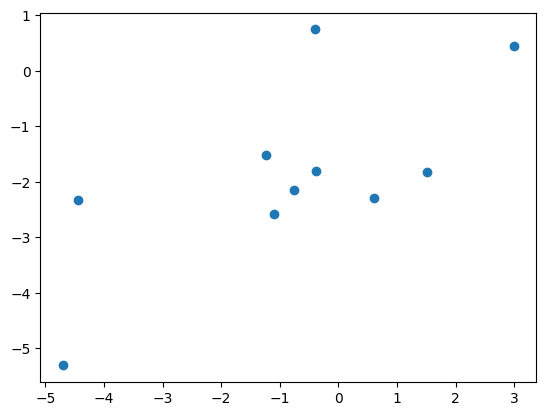

In [9]:
N = 10
# (-5, 5)
X = np.random.random(N) * 10 - 5
y = 0.5 * X - 1 + np.random.randn(N)

plt.scatter(X, y)

In [23]:
model = nn.Linear(1, 1)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

X = X.reshape(N, 1)
y = y.reshape(N, 1)

# NumPy creates `float64` by default
inputs = torch.from_numpy(X.astype(np.float32))
targets = torch.from_numpy(y.astype(np.float32))

type(inputs)

torch.Tensor

In [29]:
print(inputs)

tensor([[-0.7517],
        [-1.1045],
        [-1.2412],
        [-0.3923],
        [ 2.9923],
        [ 0.6128],
        [ 1.5206],
        [-4.7027],
        [-0.3810],
        [-4.4450]])


In [30]:
print(targets)

tensor([[-2.1424],
        [-2.5755],
        [-1.5125],
        [ 0.7460],
        [ 0.4411],
        [-2.2813],
        [-1.8139],
        [-5.3069],
        [-1.8115],
        [-2.3218]])


In [24]:
print("Optimizer's `state_dict`:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's `state_dict`:
state 	 {}
param_groups 	 [{'lr': 0.05, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None, 'params': [0, 1]}]


In [25]:
print("Model's `state_dict`:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's `state_dict`:
weight 	 torch.Size([1, 1])
bias 	 torch.Size([1])


In [26]:
optimizer.zero_grad()

print("Optimizer's `state_dict`:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's `state_dict`:
state 	 {}
param_groups 	 [{'lr': 0.05, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None, 'params': [0, 1]}]


In [27]:
outputs = model(inputs)

print("Model's `state_dict`:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor])
    # print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's `state_dict`:
weight 	 tensor([[0.7652]])
bias 	 tensor([-0.3949])


In [28]:
# input * weight + bias
print(outputs)

tensor([[-0.9701],
        [-1.2401],
        [-1.3446],
        [-0.6951],
        [ 1.8947],
        [ 0.0740],
        [ 0.7686],
        [-3.9934],
        [-0.6865],
        [-3.7962]], grad_fn=<AddmmBackward0>)


In [31]:
# sum((output - target)^2) / 10 = 2.4758
loss = criterion(outputs, targets)
print(loss)

tensor(2.4758, grad_fn=<MseLossBackward0>)


In [32]:
loss.backward()

In [41]:
print(model.weight.grad)
print(model.bias.grad)

tensor([[1.5338]])
tensor([1.7180])


In [42]:
optimizer.step()

In [43]:
# Nothing changes
print("Optimizer's `state_dict`:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's `state_dict`:
state 	 {}
param_groups 	 [{'lr': 0.05, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None, 'params': [0, 1]}]


In [44]:
# 0.7652 - 1.5338 * 0.05 = 0.7652 - 0.07669 = 0.6885
# -0.3949 - 1.7180 * 0.05 = -0.4808
print("Model's `state_dict`:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor])

Model's `state_dict`:
weight 	 tensor([[0.6885]])
bias 	 tensor([-0.4808])


In [45]:
optimizer.zero_grad()

In [46]:
# Nothing changes
print("Optimizer's `state_dict`:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's `state_dict`:
state 	 {}
param_groups 	 [{'lr': 0.05, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'fused': None, 'params': [0, 1]}]


In [47]:
# Nothing changes
print("Model's `state_dict`:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor])

Model's `state_dict`:
weight 	 tensor([[0.6885]])
bias 	 tensor([-0.4808])


In [48]:
print(model.weight.grad)
print(model.bias.grad)

None
None


In [4]:
n_epochs = 30
losses = []
for it in range(n_epochs):
    optimizer.zero_grad()
    
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    losses.append(loss.item())

    loss.backward()
    optimizer.step()

    print(f"Epoch {it+1}/{n_epochs}, Loss: {loss.item():.4f}")

Epoch 1/30, Loss: 3.7359
Epoch 2/30, Loss: 3.2713
Epoch 3/30, Loss: 2.9047
Epoch 4/30, Loss: 2.5957
Epoch 5/30, Loss: 2.3300
Epoch 6/30, Loss: 2.1002
Epoch 7/30, Loss: 1.9012
Epoch 8/30, Loss: 1.7288
Epoch 9/30, Loss: 1.5794
Epoch 10/30, Loss: 1.4499
Epoch 11/30, Loss: 1.3377
Epoch 12/30, Loss: 1.2405
Epoch 13/30, Loss: 1.1563
Epoch 14/30, Loss: 1.0833
Epoch 15/30, Loss: 1.0200
Epoch 16/30, Loss: 0.9652
Epoch 17/30, Loss: 0.9177
Epoch 18/30, Loss: 0.8765
Epoch 19/30, Loss: 0.8408
Epoch 20/30, Loss: 0.8099
Epoch 21/30, Loss: 0.7831
Epoch 22/30, Loss: 0.7599
Epoch 23/30, Loss: 0.7398
Epoch 24/30, Loss: 0.7223
Epoch 25/30, Loss: 0.7072
Epoch 26/30, Loss: 0.6941
Epoch 27/30, Loss: 0.6828
Epoch 28/30, Loss: 0.6730
Epoch 29/30, Loss: 0.6644
Epoch 30/30, Loss: 0.6571


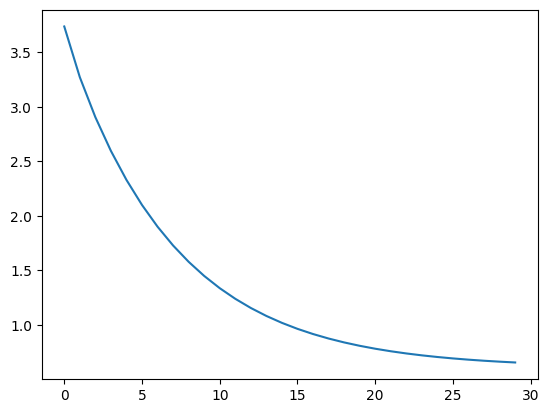

In [5]:
plt.plot(losses)

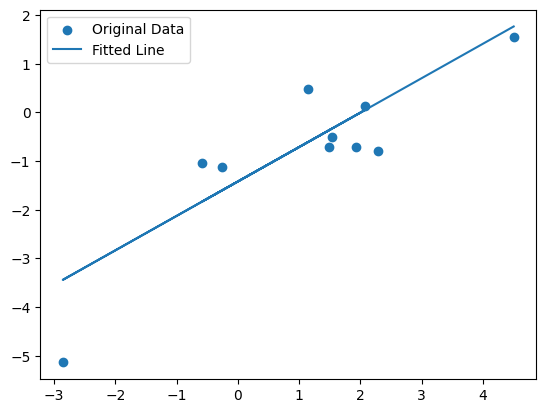

In [6]:
predictions = model(inputs).detach().numpy()
plt.scatter(X, y, label="Original Data")
plt.plot(X, predictions, label="Fitted Line")
plt.legend()
plt.show()

In [7]:
w = model.weight.data.numpy()
b = model.bias.data.numpy()
# (0.5, -1)
print(w, b)

[[0.70741653]] [-1.4193791]


# 3. Logistic Regression

# 4. Deep Neural Networks (DNNs)
# 5. Convolutional Neural Networks (CNNs)
# 6. Recurrent Neural Networks (RNNs)
## 6-1. RNN
## 6-2. GRU
## 6-3. LSTM